In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Response Generation/')

In [2]:
import pandas as pd
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Concatenate, Dropout, RepeatVector
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers

In [3]:
# Load the dataset
df = pd.read_csv('emotion-emotion_69k - emotion-emotion_69k.csv')

In [4]:
# Select a subset of data for quick experimentation
data = df[['empathetic_dialogues', 'emotion', 'labels']]
data = data[:10000]

In [5]:
# Extract dialogues, emotions, and labels into separate lists
dialogues_list = data['empathetic_dialogues'].tolist()
emotions_list = data['emotion'].tolist()
labels_list = data['labels'].tolist()

In [6]:
# Clean dialogues
cleaned_dialogues_list = [str(dialogue).replace('Customer :', '').replace('\nAgent :', '') if not pd.isna(dialogue) else '' for dialogue in dialogues_list]

# Clean labels
cleaned_labels_list = [' '.join(line.split()[:15]) for line in labels_list]

In [7]:
import re

# Preprocess text
def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is", txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"can't", "can not", txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt

In [8]:
clean_ques = [clean_text(line) for line in cleaned_dialogues_list]
clean_ans = [clean_text(line) for line in cleaned_labels_list]

In [9]:
# Build vocabulary
word2count = {}
for line in clean_ques + clean_ans:
    for word in line.split():
        word2count[word] = word2count.get(word, 0) + 1

In [10]:
# Set threshold for word inclusion
thresh = 5
vocab = {}
word_num = 0

for word, count in word2count.items():
    if count >= thresh:
        vocab[word] = word_num
        word_num += 1

In [11]:
# Add special tokens
vocab.update({'<PAD>': word_num, '<EOS>': word_num + 1, '<OUT>': word_num + 2, '<SOS>': word_num + 3})

inv_vocab = {v: k for k, v in vocab.items()}

In [12]:
# Convert sentences to sequences of indices
encoder_inp = [[vocab.get(word, vocab['<OUT>']) for word in line.split()] for line in clean_ques]
decoder_inp = [[vocab.get(word, vocab['<OUT>']) for word in ('<SOS> ' + line + ' <EOS>').split()] for line in clean_ans]

# Pad sequences
encoder_inp = pad_sequences(encoder_inp, 15, padding='post', truncating='post')
decoder_inp = pad_sequences(decoder_inp, 15, padding='post', truncating='post')

In [13]:
# Prepare decoder final output
decoder_final_output = pad_sequences([line[1:] for line in decoder_inp], 15, padding='post', truncating='post')

# Convert to categorical
decoder_final_output = to_categorical(decoder_final_output, len(vocab))

In [14]:
# Glove Embedding
embeddings_index = {}
with open('glove.6B.50d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("Glove Loaded!")

Glove Loaded!


In [15]:
embedding_dim = 50
embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
# Denoising Autoencoder
input_seq = Input(shape=(15, embedding_dim))
encoded = Dense(128, activation='relu', activity_regularizer=regularizers.l2(1e-4))(input_seq)
decoded = Dense(embedding_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_seq, decoded)
encoder = Model(input_seq, encoded)

In [17]:
autoencoder.compile(optimizer='adam', loss='mse')

In [18]:
def add_noise(data, noise_factor=0.2):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy_data, 0., 1.)

In [19]:
embedding_model = Sequential()
embedding_model.add(Embedding(input_dim=len(vocab)+1,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=15,
                              trainable=False))

In [20]:
encoder_input_embeddings = embedding_model.predict(encoder_inp)
decoder_input_embeddings = embedding_model.predict(decoder_inp)

noisy_encoder_input_embeddings = add_noise(encoder_input_embeddings)
noisy_decoder_input_embeddings = add_noise(decoder_input_embeddings)

313/313 [==============================] - 1s 2ms/step


In [21]:
autoencoder.fit(noisy_encoder_input_embeddings, encoder_input_embeddings,
                epochs=200, batch_size=8, shuffle=True, validation_split=0.2)

Epoch 1/200
1000/1000 [==============================] - 4s 3ms/step - loss: 0.3985 - val_loss: 0.3695
Epoch 2/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3609 - val_loss: 0.3605
Epoch 3/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3549 - val_loss: 0.3567
Epoch 4/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3519 - val_loss: 0.3543
Epoch 5/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3497 - val_loss: 0.3524
Epoch 6/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3480 - val_loss: 0.3511
Epoch 7/200
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3468 - val_loss: 0.3501
Epoch 8/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3459 - val_loss: 0.3493
Epoch 9/200
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3452 - val_loss: 0.3487
Epoch 10/200
1000/1000 [==============================] - 3s 3ms/step - l

In [22]:
encoder_inp_encoded = encoder.predict(encoder_input_embeddings)
decoder_inp_encoded = encoder.predict(decoder_input_embeddings)

# Emotion Encoding
emotion_vocab = {emotion: idx for idx, emotion in enumerate(set(emotions_list))}
emotion_inp = np.array([emotion_vocab[emotion] for emotion in emotions_list])
emotion_inp = to_categorical(emotion_inp, len(emotion_vocab))

313/313 [==============================] - 1s 2ms/step


In [23]:
# Main Model
enc_inp = Input(shape=(15, 128))
emotion_inp_layer = Input(shape=(len(emotion_vocab),))
emotion_repeated = RepeatVector(15)(emotion_inp_layer)
merged_inp = Concatenate()([enc_inp, emotion_repeated])

dec_inp = Input(shape=(15, 128))

enc_lstm = Bidirectional(LSTM(400, return_state=True, dropout=0.3, return_sequences=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = enc_lstm(merged_inp)

state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
enc_states = [state_h, state_c]

dec_lstm = LSTM(400 * 2, return_state=True, return_sequences=True, dropout=0.3)
output, _, _ = dec_lstm(dec_inp, initial_state=enc_states)

dec_dense = Dense(len(vocab), activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
final_output = dec_dense(output)

In [24]:
model = Model([enc_inp, emotion_inp_layer, dec_inp], final_output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Training the main model
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit([encoder_inp_encoded, emotion_inp, decoder_inp_encoded], decoder_final_output,
                    epochs=100, batch_size=128, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
63/63 [==============================] - 174s 3s/step - loss: 4.6219 - accuracy: 0.2987 - val_loss: 4.0016 - val_accuracy: 0.3535 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 132s 2s/step - loss: 4.1264 - accuracy: 0.3226 - val_loss: 3.7962 - val_accuracy: 0.3734 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 142s 2s/step - loss: 3.9669 - accuracy: 0.3372 - val_loss: 3.6893 - val_accuracy: 0.3882 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 140s 2s/step - loss: 3.8550 - accuracy: 0.3469 - val_loss: 3.6101 - val_accuracy: 0.3938 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - 141s 2s/step - loss: 3.7725 - accuracy: 0.3536 - val_loss: 3.5546 - val_accuracy: 0.4016 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 141s 2s/step - loss: 3.7053 - accuracy: 0.3592 - val_loss: 3.5226 - val_accuracy: 0.4040 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - 141s 2s/step - lo

In [26]:
model.save('chatbot_emotion.keras')
model.save_weights('chatbot_weights_emotion.keras')

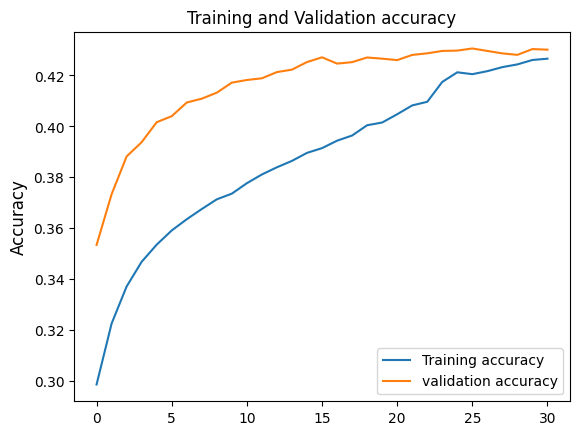

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])
plt.title("Training and Validation accuracy")
plt.ylabel('Accuracy', fontsize="large")
plt.legend(['Training accuracy','validation accuracy'])
plt.show()

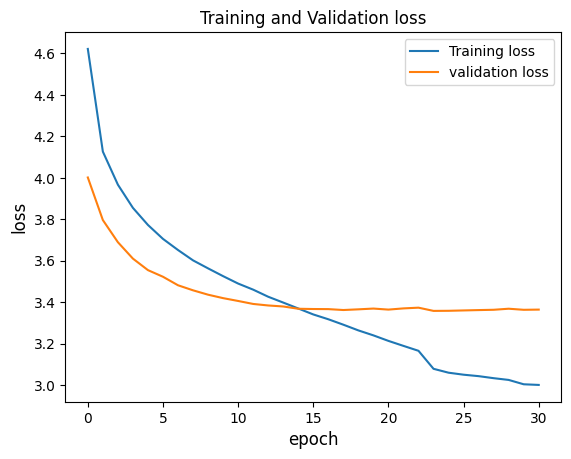

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"])
plt.title("Training and Validation loss")
plt.ylabel("loss", fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(['Training loss','validation loss'])
plt.show()

In [29]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00


In [30]:
# Predict using the trained model
predictions = model.predict([encoder_inp_encoded, emotion_inp, decoder_inp_encoded])
# Assuming predictions are one-hot encoded, convert them to class labels
predicted_labels = np.argmax(predictions, axis=2)

313/313 [==============================] - 88s 272ms/step


In [31]:
# Compute BLEU score
# Convert integer sequences back to sentences
def sequences_to_texts(sequences, inv_vocab):
    texts = []
    for sequence in sequences:
        text = ' '.join([inv_vocab[i] for i in sequence if i != 0])
        texts.append(text)
    return texts

predicted_texts = sequences_to_texts(predicted_labels, inv_vocab)
true_texts = sequences_to_texts(np.argmax(decoder_final_output, axis=2), inv_vocab)

In [32]:
import evaluate

# Load the BLEU evaluation metric
bleu = evaluate.load("bleu")

# Compute the BLEU score
results1 = bleu.compute(predictions=predicted_texts, references=true_texts)

# Print the results
print(results1)

{'bleu': 0.09391306678227403, 'precisions': [0.3096509240246407, 0.15064958377274665, 0.08258214597266647, 0.020191919723523324], 'brevity_penalty': 1.0, 'length_ratio': 1.1568627450980393, 'translation_length': 143665, 'reference_length': 124185}


In [33]:
from sklearn.metrics import jaccard_score
import numpy as np

# Function to compute Jaccard index for individual pairs of texts
def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Convert texts to sets of words
predicted_sets = [set(text.split()) for text in predicted_texts]
true_sets = [set(text.split()) for text in true_texts]

# Compute Jaccard indices for all pairs
jaccard_indices = [jaccard_index(pred, true) for pred, true in zip(predicted_sets, true_sets)]

# Average Jaccard index
average_jaccard_index = np.mean(jaccard_indices)

print("Average Jaccard Index:", average_jaccard_index)

Average Jaccard Index: 0.1943673480584005


In [35]:
# Assuming you have the model and test data ready
test_loss, _ = model.evaluate([encoder_inp_encoded, emotion_inp, decoder_inp_encoded], decoder_final_output)
perplexity = np.exp(test_loss)
print("Perplexity:", perplexity)

313/313 [==============================] - 74s 237ms/step - loss: 3.0259 - accuracy: 0.4335
Perplexity: 20.61310558182767
